# CSAFE 데이터셋 작성자별 분포 분석

이 노트북은 CSAFE 필기 데이터셋의 실제 작성자별 데이터 분포를 분석합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from collections import Counter

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 1. CSV 메타데이터 로드 및 기본 통계
csv_path = "/workspace/MIL/data/raw/naver_ocr.csv"
print(f"CSV 파일 경로: {csv_path}")

# CSV 파일 로드
df = pd.read_csv(csv_path)
print(f"\n전체 데이터 행 수: {len(df):,}")
print(f"컬럼: {df.columns.tolist()}")
print(f"\n처음 5행:")
print(df.head())

# 기본 통계
print(f"\n라벨 범위: {df['label'].min()} ~ {df['label'].max()}")
print(f"고유 라벨 수: {df['label'].nunique()}")

CSV 파일 경로: /workspace/MIL/data/raw/naver_ocr.csv

전체 데이터 행 수: 556,128
컬럼: ['image_path', 'label', 'text']

처음 5행:
                           image_path  label    text
0   /content/xai_train/0/"Y.X._13.png      0      yx
1    /content/xai_train/0/'YX'_17.png      0      yx
2     /content/xai_train/0/-he_10.png      0      he
3      /content/xai_train/0/-ne_9.png      0      ne
4  /content/xai_train/0/Athens_18.png      0  athens

라벨 범위: 0 ~ 474
고유 라벨 수: 475


In [2]:
# 2. 작성자별 데이터 분포 분석
writer_counts = df['label'].value_counts().sort_index()

# 실제 이미지 파일이 존재하는 라벨 범위 확인 (0-299)
actual_writers = writer_counts[writer_counts.index < 300]

print(f"\n실제 존재하는 작성자 (0-299) 통계:")
print(f"작성자 수: {len(actual_writers)}")
print(f"작성자당 평균 이미지 수: {actual_writers.mean():.2f}")
print(f"표준편차: {actual_writers.std():.2f}")
print(f"최소 이미지 수: {actual_writers.min()}")
print(f"최대 이미지 수: {actual_writers.max()}")
print(f"중앙값: {actual_writers.median()}")


실제 존재하는 작성자 (0-299) 통계:
작성자 수: 300
작성자당 평균 이미지 수: 1171.04
표준편차: 97.72
최소 이미지 수: 580
최대 이미지 수: 1385
중앙값: 1200.5


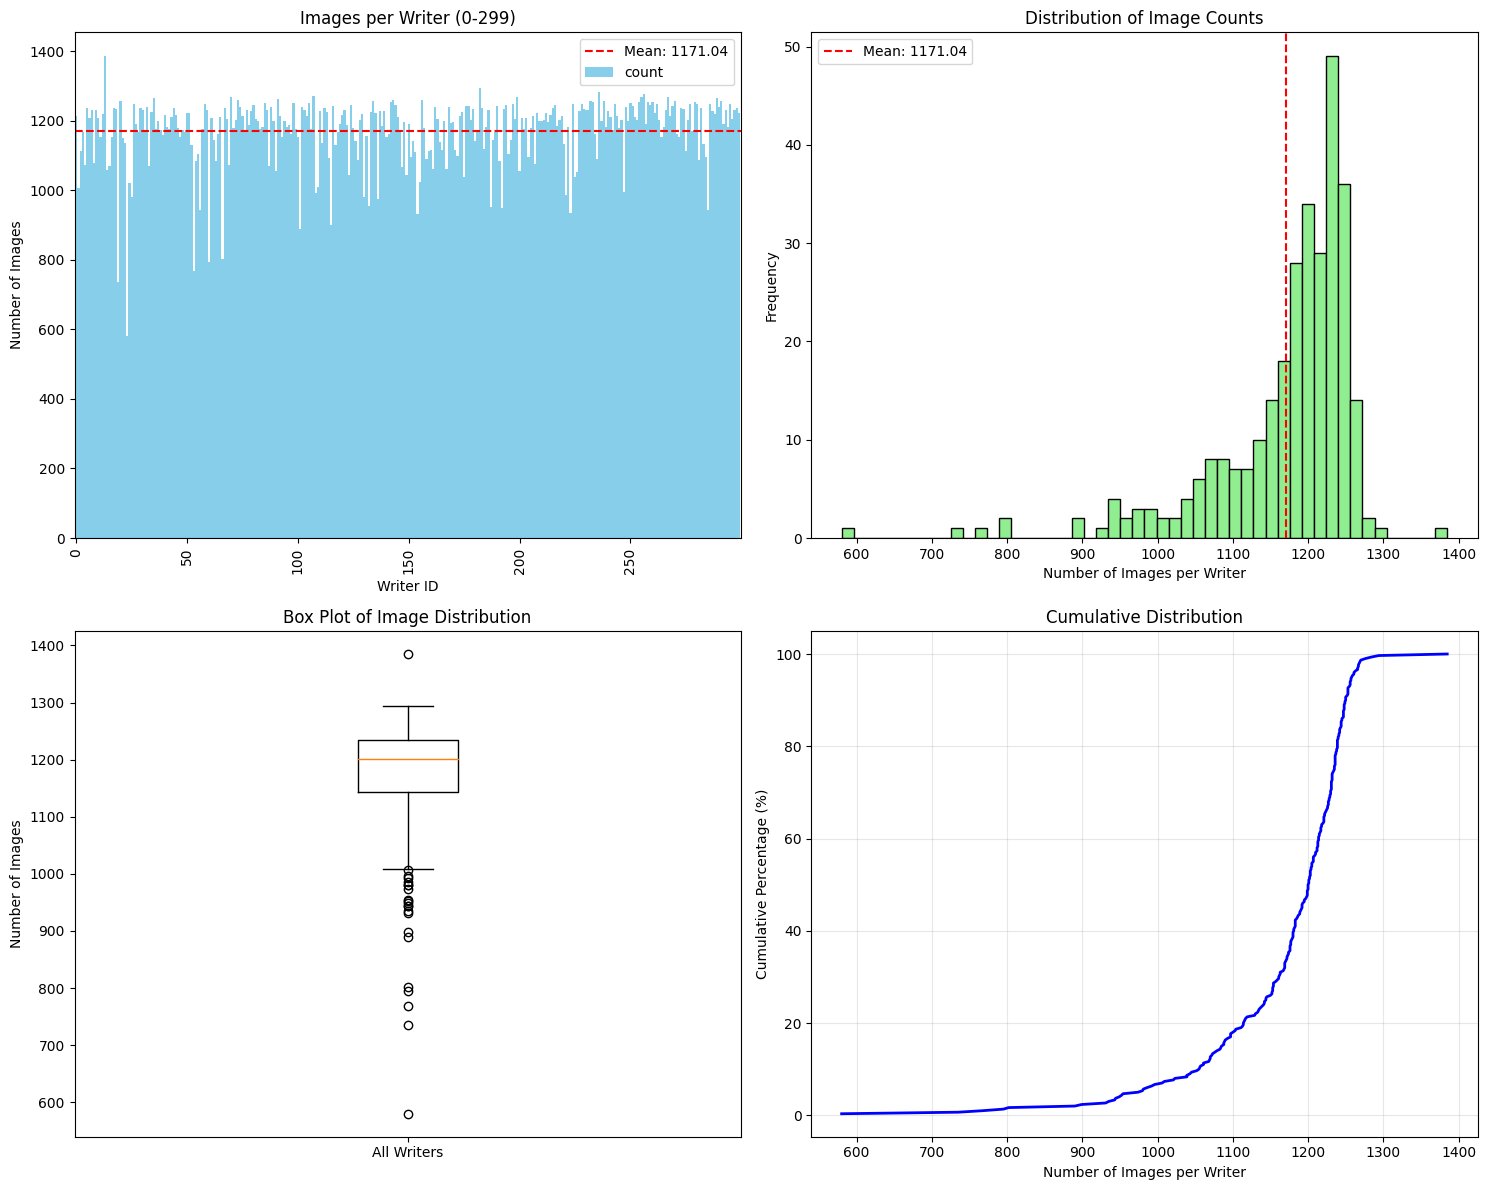


분포 요약:
변동 계수 (CV): 8.35%
최소-최대 범위: 805
Q1 (25%): 1144.0
Q3 (75%): 1235.0
IQR: 91.0


In [3]:
# 3. 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 3-1. 작성자별 이미지 수 막대 그래프
ax1 = axes[0, 0]
actual_writers.plot(kind='bar', ax=ax1, color='skyblue', width=1.0)
ax1.set_xlabel('Writer ID')
ax1.set_ylabel('Number of Images')
ax1.set_title('Images per Writer (0-299)')
ax1.set_xticks(range(0, 300, 50))
ax1.axhline(y=actual_writers.mean(), color='red', linestyle='--', label=f'Mean: {actual_writers.mean():.2f}')
ax1.legend()

# 3-2. 히스토그램
ax2 = axes[0, 1]
ax2.hist(actual_writers.values, bins=50, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Number of Images per Writer')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Image Counts')
ax2.axvline(x=actual_writers.mean(), color='red', linestyle='--', label=f'Mean: {actual_writers.mean():.2f}')
ax2.legend()

# 3-3. 박스플롯
ax3 = axes[1, 0]
ax3.boxplot(actual_writers.values, vert=True)
ax3.set_ylabel('Number of Images')
ax3.set_title('Box Plot of Image Distribution')
ax3.set_xticklabels(['All Writers'])

# 3-4. 누적 분포
ax4 = axes[1, 1]
sorted_counts = sorted(actual_writers.values)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
ax4.plot(sorted_counts, cumulative, 'b-', linewidth=2)
ax4.set_xlabel('Number of Images per Writer')
ax4.set_ylabel('Cumulative Percentage (%)')
ax4.set_title('Cumulative Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/workspace/MIL/output/figures/writer_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 통계 요약
print(f"\n분포 요약:")
print(f"변동 계수 (CV): {actual_writers.std() / actual_writers.mean() * 100:.2f}%")
print(f"최소-최대 범위: {actual_writers.max() - actual_writers.min()}")
print(f"Q1 (25%): {actual_writers.quantile(0.25)}")
print(f"Q3 (75%): {actual_writers.quantile(0.75)}")
print(f"IQR: {actual_writers.quantile(0.75) - actual_writers.quantile(0.25)}")

In [4]:
# 5. 실제 이미지 파일 존재 여부 검증 (샘플링)
import random

# 무작위로 10명의 작성자 선택하여 실제 파일 확인
sample_writers = random.sample(list(range(300)), 10)
image_root = "/workspace/MIL/data/raw/csafe_version5_xai_train"

print("\n실제 파일 존재 여부 검증 (10명 샘플):")
for writer_id in sorted(sample_writers):
    writer_folder = os.path.join(image_root, str(writer_id))
    if os.path.exists(writer_folder):
        actual_files = len([f for f in os.listdir(writer_folder) if f.endswith('.png')])
        csv_count = len(df[df['label'] == writer_id])
        print(f"  작성자 {writer_id}: CSV={csv_count}개, 실제 파일={actual_files}개", end="")
        if csv_count == actual_files:
            print(" ✓ 일치")
        else:
            print(f" ✗ 불일치 (차이: {abs(csv_count - actual_files)})")
    else:
        print(f"  작성자 {writer_id}: 폴더가 존재하지 않음!")


실제 파일 존재 여부 검증 (10명 샘플):
  작성자 22: CSV=1137개, 실제 파일=1137개 ✓ 일치
  작성자 45: CSV=1216개, 실제 파일=1216개 ✓ 일치
  작성자 66: CSV=802개, 실제 파일=802개 ✓ 일치
  작성자 113: CSV=1225개, 실제 파일=1225개 ✓ 일치
  작성자 178: CSV=1202개, 실제 파일=1202개 ✓ 일치
  작성자 192: CSV=949개, 실제 파일=949개 ✓ 일치
  작성자 226: CSV=1052개, 실제 파일=1052개 ✓ 일치
  작성자 241: CSV=1212개, 실제 파일=1212개 ✓ 일치
  작성자 243: CSV=1247개, 실제 파일=1247개 ✓ 일치
  작성자 284: CSV=1097개, 실제 파일=1097개 ✓ 일치


In [5]:
# 7. 클래스 불균형 분석 및 권장사항
print("\n클래스 불균형 분석:")

# Gini 계수 계산 (불균형 정도 측정)
def gini_coefficient(counts):
    sorted_counts = sorted(counts)
    n = len(counts)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n

gini = gini_coefficient(actual_writers.values)
print(f"Gini 계수: {gini:.4f} (0=완벽한 균형, 1=완전한 불균형)")

# 불균형 비율
imbalance_ratio = actual_writers.max() / actual_writers.min()
print(f"불균형 비율 (최대/최소): {imbalance_ratio:.2f}")

# 권장사항
print("\n권장사항:")
if gini < 0.1:
    print("✓ 매우 균형잡힌 데이터셋입니다. 별도의 클래스 균형 조정이 필요하지 않습니다.")
elif gini < 0.2:
    print("✓ 적절히 균형잡힌 데이터셋입니다. 선택적으로 가중치 조정을 고려할 수 있습니다.")
else:
    print("⚠️ 클래스 불균형이 존재합니다. 다음 방법을 고려하세요:")
    print("  - 클래스별 가중치 적용")
    print("  - 언더샘플링 또는 오버샘플링")
    print("  - Focal Loss 등 불균형에 강건한 손실 함수 사용")

# 최종 요약 보고서
print("\n=== 최종 데이터 분포 요약 ===")
print(f"총 작성자 수: {len(actual_writers)}")
print(f"총 이미지 수: {actual_writers.sum():,}")
print(f"작성자당 평균: {actual_writers.mean():.2f} ± {actual_writers.std():.2f}")
print(f"중앙값: {actual_writers.median()}")
print(f"최소-최대: {actual_writers.min()} - {actual_writers.max()}")
print(f"변동계수: {actual_writers.std() / actual_writers.mean() * 100:.2f}%")
print(f"Gini 계수: {gini:.4f}")

# 데이터 분할 추천
total_writers = len(actual_writers)
train_size = int(total_writers * 0.6)
val_size = int(total_writers * 0.2)
test_size = total_writers - train_size - val_size

print(f"\n추천 데이터 분할 (60:20:20):")
print(f"  Train: 0-{train_size-1} ({train_size}명)")
print(f"  Val: {train_size}-{train_size+val_size-1} ({val_size}명)")
print(f"  Test: {train_size+val_size}-{total_writers-1} ({test_size}명)")


클래스 불균형 분석:
Gini 계수: 0.0404 (0=완벽한 균형, 1=완전한 불균형)
불균형 비율 (최대/최소): 2.39

권장사항:
✓ 매우 균형잡힌 데이터셋입니다. 별도의 클래스 균형 조정이 필요하지 않습니다.

=== 최종 데이터 분포 요약 ===
총 작성자 수: 300
총 이미지 수: 351,311
작성자당 평균: 1171.04 ± 97.72
중앙값: 1200.5
최소-최대: 580 - 1385
변동계수: 8.35%
Gini 계수: 0.0404

추천 데이터 분할 (60:20:20):
  Train: 0-179 (180명)
  Val: 180-239 (60명)
  Test: 240-299 (60명)



반복(repetition) 분포 분석:
사용 가능한 컬럼: ['image_path', 'label', 'text']
image_path에서 repetition 추출 완료
count    556128.000000
mean         10.945317
std           6.247980
min           1.000000
25%           6.000000
50%          11.000000
75%          15.000000
max          27.000000
Name: repetition, dtype: float64

반복 횟수별 이미지 수:
repetition
1     26613
2     26340
3     26296
4     26344
5     26347
6     26232
7     26293
8     26247
9     26371
10    30442
Name: count, dtype: int64


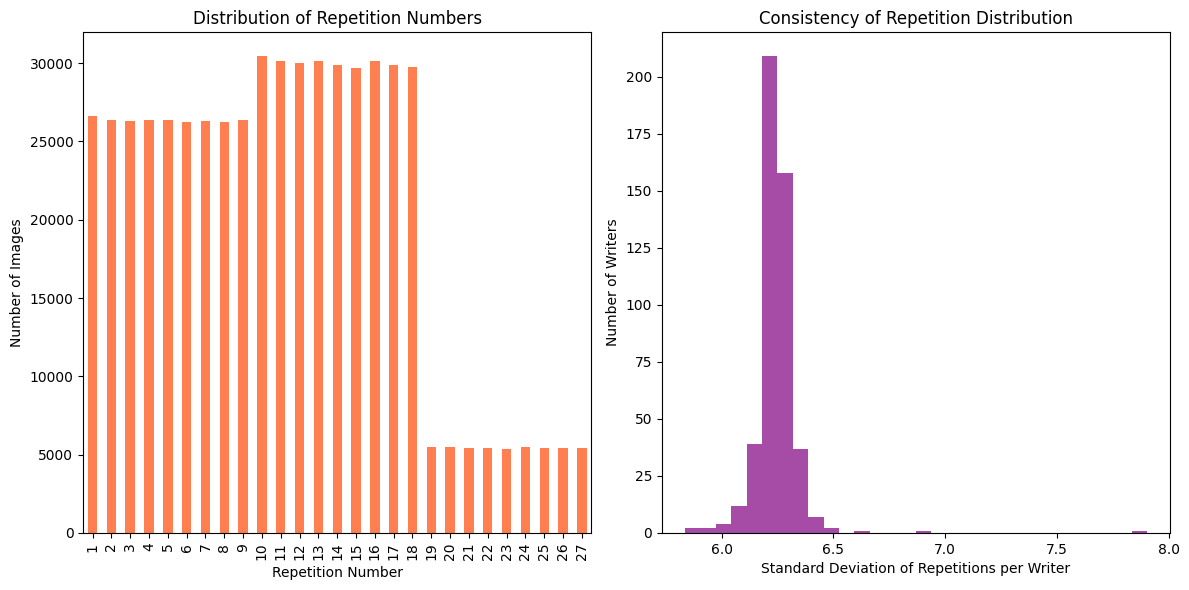

In [6]:
# 6. 반복(repetition) 분포 분석 (컬럼명 확인 후 실행)
print("\n반복(repetition) 분포 분석:")
print(f"사용 가능한 컬럼: {df.columns.tolist()}")

# repetition 컬럼이 없을 경우 파일명에서 추출
if 'repetition' not in df.columns:
    # image_path에서 반복 번호 추출 시도
    df['repetition'] = df['image_path'].str.extract(r'_(\d+)\.png$').astype(int)
    print("image_path에서 repetition 추출 완료")

if 'repetition' in df.columns:
    rep_stats = df['repetition'].describe()
    print(rep_stats)
    
    # 반복 횟수별 이미지 수
    rep_counts = df['repetition'].value_counts().sort_index()
    print(f"\n반복 횟수별 이미지 수:")
    print(rep_counts.head(10))  # 처음 10개만 출력
    
    # 반복 분포 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    rep_counts.plot(kind='bar', color='coral')
    plt.xlabel('Repetition Number')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Repetition Numbers')
    
    plt.subplot(1, 2, 2)
    # 각 작성자별 반복 횟수 분포의 일관성 확인
    writer_rep_std = df.groupby('label')['repetition'].std()
    plt.hist(writer_rep_std.values, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Standard Deviation of Repetitions per Writer')
    plt.ylabel('Number of Writers')
    plt.title('Consistency of Repetition Distribution')
    
    plt.tight_layout()
    plt.savefig('/workspace/MIL/output/figures/repetition_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("repetition 컬럼을 찾을 수 없어 분석을 건너뜁니다.")

In [7]:
# 4. 이상치 및 극단값 분석
# 평균에서 2 표준편차 이상 벗어난 작성자 찾기
mean_count = actual_writers.mean()
std_count = actual_writers.std()
outlier_threshold_low = mean_count - 2 * std_count
outlier_threshold_high = mean_count + 2 * std_count

outliers_low = actual_writers[actual_writers < outlier_threshold_low]
outliers_high = actual_writers[actual_writers > outlier_threshold_high]

print("\n이상치 분석 (평균 ± 2σ 기준):")
print(f"하한 임계값: {outlier_threshold_low:.2f}")
print(f"상한 임계값: {outlier_threshold_high:.2f}")
print(f"\n적은 데이터를 가진 작성자 (< {outlier_threshold_low:.2f}):")
if len(outliers_low) > 0:
    for writer_id, count in outliers_low.items():
        print(f"  작성자 {writer_id}: {count}개 이미지")
else:
    print("  없음")

print(f"\n많은 데이터를 가진 작성자 (> {outlier_threshold_high:.2f}):")
if len(outliers_high) > 0:
    for writer_id, count in outliers_high.items():
        print(f"  작성자 {writer_id}: {count}개 이미지")
else:
    print("  없음")

# 상위/하위 10명 작성자
print("\n상위 10명 (가장 많은 이미지):")
for writer_id, count in actual_writers.nlargest(10).items():
    print(f"  작성자 {writer_id}: {count}개")

print("\n하위 10명 (가장 적은 이미지):")
for writer_id, count in actual_writers.nsmallest(10).items():
    print(f"  작성자 {writer_id}: {count}개")


이상치 분석 (평균 ± 2σ 기준):
하한 임계값: 975.59
상한 임계값: 1366.49

적은 데이터를 가진 작성자 (< 975.59):
  작성자 19: 735개 이미지
  작성자 23: 580개 이미지
  작성자 53: 768개 이미지
  작성자 56: 943개 이미지
  작성자 60: 795개 이미지
  작성자 66: 802개 이미지
  작성자 101: 890개 이미지
  작성자 115: 899개 이미지
  작성자 132: 954개 이미지
  작성자 136: 974개 이미지
  작성자 154: 931개 이미지
  작성자 187: 952개 이미지
  작성자 192: 949개 이미지
  작성자 223: 935개 이미지
  작성자 285: 944개 이미지

많은 데이터를 가진 작성자 (> 1366.49):
  작성자 13: 1385개 이미지

상위 10명 (가장 많은 이미지):
  작성자 13: 1385개
  작성자 182: 1294개
  작성자 236: 1284개
  작성자 256: 1276개
  작성자 107: 1270개
  작성자 255: 1269개
  작성자 267: 1268개
  작성자 70: 1267개
  작성자 199: 1267개
  작성자 35: 1266개

하위 10명 (가장 적은 이미지):
  작성자 23: 580개
  작성자 19: 735개
  작성자 53: 768개
  작성자 60: 795개
  작성자 66: 802개
  작성자 101: 890개
  작성자 115: 899개
  작성자 154: 931개
  작성자 223: 935개
  작성자 56: 943개


## 고급 EDA 분석

다음 단계: 최소 필요 EDA 분석을 통한 데이터 품질 및 모델 적용성 검증

=== 세션별 데이터 완성도 분석 ===
이미지 경로 패턴 분석:
  1: /content/xai_train/0/"Y.X._13.png
  2: /content/xai_train/0/'YX'_17.png
  3: /content/xai_train/0/-he_10.png
  4: /content/xai_train/0/-ne_9.png
  5: /content/xai_train/0/Athens_18.png
  6: /content/xai_train/0/Athens_11.png
  7: /content/xai_train/0/Athens,_10.png
  8: /content/xai_train/0/Athens,_13.png
  9: /content/xai_train/0/Atmens_17.png
  10: /content/xai_train/0/Atnens ,_16.png

✓ 성공한 패턴: /(\d+)/ (556,128개 추출)

세션 통계:
count      556128.0
mean     237.556928
std      136.375158
min             0.0
25%           120.0
50%           239.0
75%           355.0
max           474.0
Name: session, dtype: Float64

세션별 작성자 데이터 매트릭스: (300, 300)
세션 수: 300
작성자 수: 300


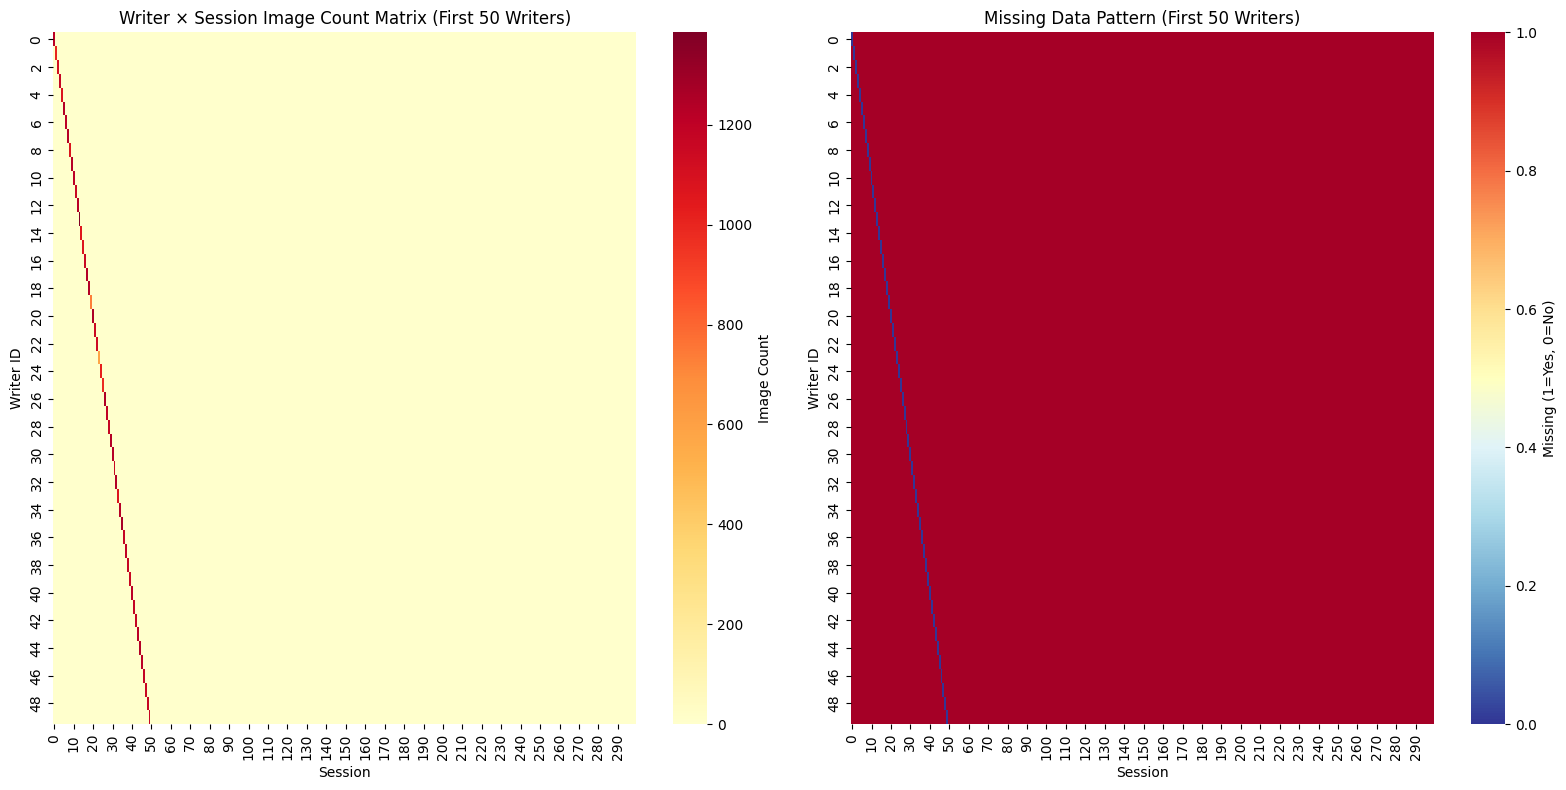


데이터 완성도 분석:
전체 셀 수: 90,000
빈 셀 수: 89,700
완성도: 0.33%

세션별 참여 작성자 수:
  세션 0: 1명 (0.3%)
  세션 1: 1명 (0.3%)
  세션 2: 1명 (0.3%)
  세션 3: 1명 (0.3%)
  세션 4: 1명 (0.3%)
  세션 5: 1명 (0.3%)
  세션 6: 1명 (0.3%)
  세션 7: 1명 (0.3%)
  세션 8: 1명 (0.3%)
  세션 9: 1명 (0.3%)
  세션 10: 1명 (0.3%)
  세션 11: 1명 (0.3%)
  세션 12: 1명 (0.3%)
  세션 13: 1명 (0.3%)
  세션 14: 1명 (0.3%)
  세션 15: 1명 (0.3%)
  세션 16: 1명 (0.3%)
  세션 17: 1명 (0.3%)
  세션 18: 1명 (0.3%)
  세션 19: 1명 (0.3%)
  세션 20: 1명 (0.3%)
  세션 21: 1명 (0.3%)
  세션 22: 1명 (0.3%)
  세션 23: 1명 (0.3%)
  세션 24: 1명 (0.3%)
  세션 25: 1명 (0.3%)
  세션 26: 1명 (0.3%)
  세션 27: 1명 (0.3%)
  세션 28: 1명 (0.3%)
  세션 29: 1명 (0.3%)
  세션 30: 1명 (0.3%)
  세션 31: 1명 (0.3%)
  세션 32: 1명 (0.3%)
  세션 33: 1명 (0.3%)
  세션 34: 1명 (0.3%)
  세션 35: 1명 (0.3%)
  세션 36: 1명 (0.3%)
  세션 37: 1명 (0.3%)
  세션 38: 1명 (0.3%)
  세션 39: 1명 (0.3%)
  세션 40: 1명 (0.3%)
  세션 41: 1명 (0.3%)
  세션 42: 1명 (0.3%)
  세션 43: 1명 (0.3%)
  세션 44: 1명 (0.3%)
  세션 45: 1명 (0.3%)
  세션 46: 1명 (0.3%)
  세션 47: 1명 (0.3%)
  세션 48: 1명 (0.3%)
  세션 49: 1명

In [8]:
# 8. 세션별 이미지 카운트 테이블 생성 및 결측치 히트맵
print("=== 세션별 데이터 완성도 분석 ===")

# 경로에서 세션 정보 추출 시도 (여러 패턴 시도)
print("이미지 경로 패턴 분석:")
sample_paths = df['image_path'].head(10).tolist()
for i, path in enumerate(sample_paths):
    print(f"  {i+1}: {path}")

# 세션 추출 패턴 시도
session_patterns = [
    r'_(\d+)/',     # _숫자/ 패턴
    r'/(\d+)/',     # /숫자/ 패턴  
    r'session_?(\d+)', # session숫자 패턴
    r'ses(\d+)',    # ses숫자 패턴
]

df['session'] = None
extracted_pattern = None

for pattern in session_patterns:
    try:
        sessions = df['image_path'].str.extract(pattern)[0]
        non_null_count = sessions.dropna().shape[0]
        if non_null_count > 0:
            df['session'] = sessions.astype('Int64')
            extracted_pattern = pattern
            print(f"\n✓ 성공한 패턴: {pattern} ({non_null_count:,}개 추출)")
            break
    except:
        continue

if extracted_pattern is None:
    print("\n⚠️ 세션 정보를 추출할 수 없습니다. 경로 구조를 확인하세요.")
    # 대안: 파일명의 마지막 숫자를 repetition으로 사용
    print("대안: 파일명에서 마지막 숫자를 세션으로 가정")
    df['session'] = df['image_path'].str.extract(r'_(\d+)\.png$')[0].astype('Int64')
    extracted_sessions = df['session'].dropna().shape[0]
    print(f"추출된 세션 정보: {extracted_sessions:,}개")

if 'session' in df.columns and df['session'].dropna().shape[0] > 0:
    # 세션 통계
    session_stats = df['session'].describe()
    print(f"\n세션 통계:")
    print(session_stats)
    
    # 작성자 × 세션 피벗 테이블 생성 (0-299 작성자만)
    df_filtered = df[df['label'] < 300].copy()
    
    if len(df_filtered) > 0:
        # 피벗 테이블: 작성자(행) × 세션(열) → 이미지 개수
        session_pivot = df_filtered.pivot_table(
            index='label', 
            columns='session', 
            values='image_path', 
            aggfunc='count', 
            fill_value=0
        )
        
        print(f"\n세션별 작성자 데이터 매트릭스: {session_pivot.shape}")
        print(f"세션 수: {session_pivot.shape[1]}")
        print(f"작성자 수: {session_pivot.shape[0]}")
        
        # 결측치 히트맵 생성
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # 왼쪽: 세션별 이미지 수 히트맵
        ax1 = axes[0]
        sns.heatmap(session_pivot.iloc[:50, :], # 처음 50명만 표시
                   cmap='YlOrRd', 
                   ax=ax1,
                   cbar_kws={'label': 'Image Count'})
        ax1.set_title('Writer × Session Image Count Matrix (First 50 Writers)')
        ax1.set_xlabel('Session')
        ax1.set_ylabel('Writer ID')
        
        # 오른쪽: 결측치(0인 셀) 히트맵
        ax2 = axes[1]
        missing_matrix = (session_pivot == 0).astype(int)
        sns.heatmap(missing_matrix.iloc[:50, :], # 처음 50명만 표시
                   cmap='RdYlBu_r',
                   ax=ax2,
                   cbar_kws={'label': 'Missing (1=Yes, 0=No)'})
        ax2.set_title('Missing Data Pattern (First 50 Writers)')
        ax2.set_xlabel('Session')
        ax2.set_ylabel('Writer ID')
        
        plt.tight_layout()
        plt.savefig('/workspace/MIL/output/figures/session_completeness_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 완성도 통계
        total_cells = session_pivot.size
        zero_cells = (session_pivot == 0).sum().sum()
        completion_rate = (total_cells - zero_cells) / total_cells * 100
        
        print(f"\n데이터 완성도 분석:")
        print(f"전체 셀 수: {total_cells:,}")
        print(f"빈 셀 수: {zero_cells:,}")
        print(f"완성도: {completion_rate:.2f}%")
        
        # 세션별 참여 작성자 수
        session_participation = (session_pivot > 0).sum()
        print(f"\n세션별 참여 작성자 수:")
        for session, count in session_participation.items():
            print(f"  세션 {session}: {count}명 ({count/len(session_pivot)*100:.1f}%)")
            
        # 작성자별 참여 세션 수
        writer_participation = (session_pivot > 0).sum(axis=1)
        print(f"\n작성자별 참여 세션 통계:")
        print(f"평균 참여 세션: {writer_participation.mean():.2f}")
        print(f"최소 참여 세션: {writer_participation.min()}")
        print(f"최대 참여 세션: {writer_participation.max()}")
        print(f"모든 세션 참여 작성자: {(writer_participation == session_pivot.shape[1]).sum()}명")
else:
    print("세션 정보 추출 실패 - 다음 분석으로 넘어갑니다.")

=== 텍스트 특성 분석 ===
평균 텍스트 길이: 4.55
텍스트 길이 중앙값: 4.00
텍스트 길이 표준편차: 1.97
작성자별 텍스트 길이 Gini 계수 평균: 0.240
Gini 계수가 높은 상위 5명 작성자: [267, 283, 187, 221, 25]
평균 길이 선호도 분포:
  짧은 단어 선호 (평균 < 5자): 283명
  중간 길이 선호 (5-8자): 17명
  긴 단어 선호 (평균 > 8자): 0명

문자 유형 사용 패턴:
평균 알파벳 사용: 4.56개
평균 숫자 사용: 0.00개
평균 특수문자 사용: 0.00개
평균 대문자 비율: 0.000

단어 다양성 분석:
평균 단어 다양성 비율: 0.384
가장 다양한 단어 사용 작성자 상위 5명: [187, 25, 1, 53, 283]
반복 단어 사용이 많은 작성자 상위 5명: [190, 233, 298, 299, 88]


/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5585/1104025717.py:101

/tmp/ipykernel_5585/1104025717.py:102: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  plt.savefig('/workspace/MIL/output/figures/text_analysis.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_5585/1104025717.py:102: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.savefig('/workspace/MIL/output/figures/text_analysis.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_5585/1104025717.py:102: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  plt.savefig('/workspace/MIL/output/figures/text_analysis.png', dpi=300, bbox_inches='tight')
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig

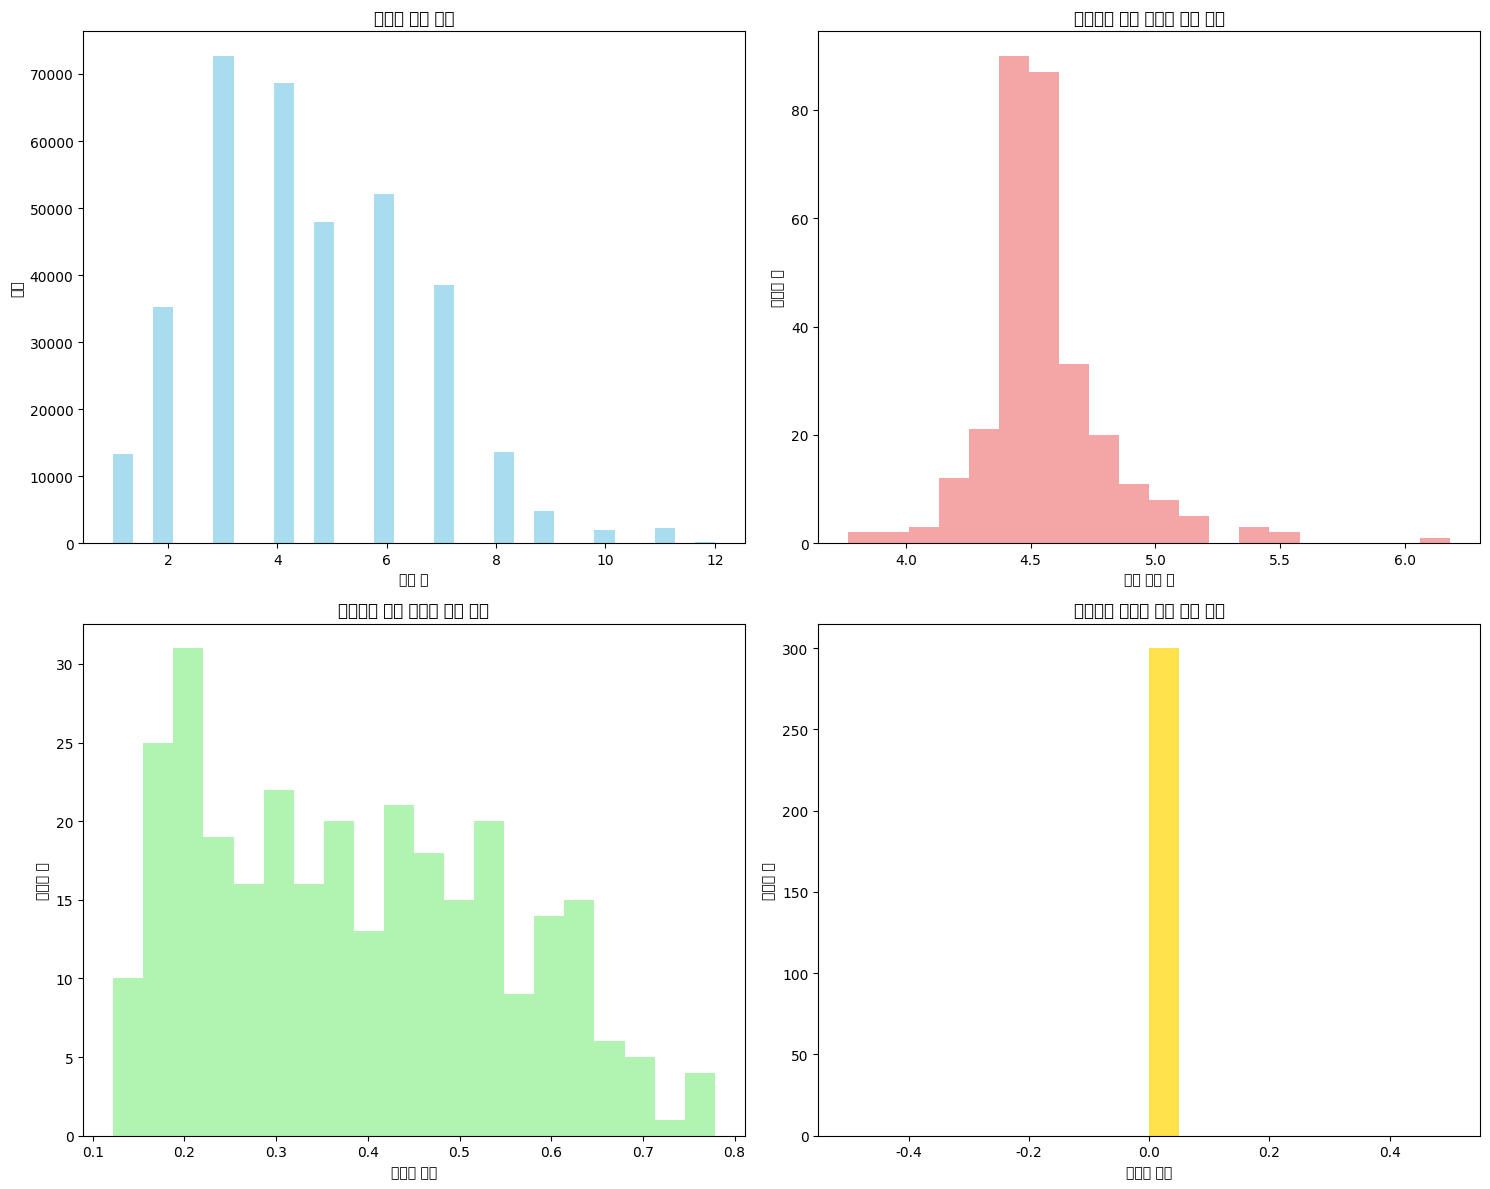


=== 텍스트 특성 이상치 탐지 ===
극단적으로 짧은 텍스트 작성자 (0명): []
극단적으로 긴 텍스트 작성자 (0명): []
단어 다양성이 낮은 작성자 (111명): [5, 6, 12, 13, 17, 18, 26, 30, 32, 38, 43, 50, 51, 58, 59, 69, 70, 71, 73, 75, 76, 79, 80, 81, 84, 85, 88, 91, 98, 104, 105, 106, 110, 116, 118, 121, 131, 133, 134, 135, 137, 138, 139, 142, 143, 144, 145, 148, 150, 156, 157, 162, 166, 168, 174, 176, 177, 178, 179, 180, 185, 186, 190, 193, 196, 205, 206, 208, 212, 214, 216, 218, 220, 222, 224, 228, 229, 230, 231, 232, 233, 234, 238, 240, 241, 242, 243, 246, 248, 249, 254, 255, 258, 259, 261, 262, 268, 270, 273, 276, 277, 279, 280, 282, 287, 288, 289, 295, 296, 298, 299]
단어 다양성이 높은 작성자 (0명): []
텍스트 특성 분석 완료


In [9]:
# Cell 10: 텍스트 특성 분석
print("=== 텍스트 특성 분석 ===")

# 텍스트 길이 및 특성 컬럼 추가
df_text_analysis = df_filtered.copy()
df_text_analysis['text_length'] = df_text_analysis['text'].str.len()
df_text_analysis['alphabets'] = df_text_analysis['text'].str.count(r'[a-zA-Z]')
df_text_analysis['digits'] = df_text_analysis['text'].str.count(r'[0-9]')
df_text_analysis['special_chars'] = df_text_analysis['text'].str.count(r'[^a-zA-Z0-9]')
df_text_analysis['uppercase_ratio'] = df_text_analysis['text'].str.count(r'[A-Z]') / df_text_analysis['text_length']

# 기본 통계
print(f"평균 텍스트 길이: {df_text_analysis['text_length'].mean():.2f}")
print(f"텍스트 길이 중앙값: {df_text_analysis['text_length'].median():.2f}")
print(f"텍스트 길이 표준편차: {df_text_analysis['text_length'].std():.2f}")

# 1. 작성자별 텍스트 길이 분포 불균등 정도 (Gini 계수)
try:
    def calculate_gini(x):
        n = len(x)
        x_sorted = np.sort(x)
        cumsum = np.cumsum(x_sorted)
        return (n + 1 - 2 * sum(cumsum) / cumsum[-1]) / n
    
    writer_length_gini = df_text_analysis.groupby('label')['text_length'].apply(calculate_gini)
    print(f"작성자별 텍스트 길이 Gini 계수 평균: {writer_length_gini.mean():.3f}")
    print(f"Gini 계수가 높은 상위 5명 작성자: {writer_length_gini.nlargest(5).index.tolist()}")
except:
    print("Gini 계수 계산 실패")

# 2. 작성자별 길이 선호도 분석 (mode 함수 수정)
def safe_mode(series):
    """안전한 mode 계산 함수"""
    try:
        mode_result = series.mode()
        return mode_result.iloc[0] if len(mode_result) > 0 else series.median()
    except:
        return series.median()

writer_length_stats = df_text_analysis.groupby('label')['text_length'].agg([
    'mean', 
    'median',
    safe_mode
]).round(2)
writer_length_stats.columns = ['mean_length', 'median_length', 'mode_length']

# 작성자별 선호 길이 분포
print(f"평균 길이 선호도 분포:")
print(f"  짧은 단어 선호 (평균 < 5자): {(writer_length_stats['mean_length'] < 5).sum()}명")
print(f"  중간 길이 선호 (5-8자): {((writer_length_stats['mean_length'] >= 5) & (writer_length_stats['mean_length'] <= 8)).sum()}명")
print(f"  긴 단어 선호 (평균 > 8자): {(writer_length_stats['mean_length'] > 8).sum()}명")

# 3. 문자 유형별 분석
char_type_analysis = df_text_analysis.groupby('label')[['alphabets', 'digits', 'special_chars', 'uppercase_ratio']].mean()

print(f"\n문자 유형 사용 패턴:")
print(f"평균 알파벳 사용: {char_type_analysis['alphabets'].mean():.2f}개")
print(f"평균 숫자 사용: {char_type_analysis['digits'].mean():.2f}개")
print(f"평균 특수문자 사용: {char_type_analysis['special_chars'].mean():.2f}개")
print(f"평균 대문자 비율: {char_type_analysis['uppercase_ratio'].mean():.3f}")

# 4. 단어 다양성 분석
word_diversity = df_text_analysis.groupby('label')['text'].agg([
    'nunique',  # 고유 단어 수
    'count'     # 총 단어 수
])
word_diversity['diversity_ratio'] = word_diversity['nunique'] / word_diversity['count']

print(f"\n단어 다양성 분석:")
print(f"평균 단어 다양성 비율: {word_diversity['diversity_ratio'].mean():.3f}")
print(f"가장 다양한 단어 사용 작성자 상위 5명: {word_diversity['diversity_ratio'].nlargest(5).index.tolist()}")
print(f"반복 단어 사용이 많은 작성자 상위 5명: {word_diversity['diversity_ratio'].nsmallest(5).index.tolist()}")

# 5. 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 텍스트 길이 분포
axes[0,0].hist(df_text_analysis['text_length'], bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('텍스트 길이 분포')
axes[0,0].set_xlabel('문자 수')
axes[0,0].set_ylabel('빈도')

# 작성자별 평균 길이 분포
axes[0,1].hist(writer_length_stats['mean_length'], bins=20, alpha=0.7, color='lightcoral')
axes[0,1].set_title('작성자별 평균 텍스트 길이 분포')
axes[0,1].set_xlabel('평균 문자 수')
axes[0,1].set_ylabel('작성자 수')

# 단어 다양성 분포
axes[1,0].hist(word_diversity['diversity_ratio'], bins=20, alpha=0.7, color='lightgreen')
axes[1,0].set_title('작성자별 단어 다양성 비율 분포')
axes[1,0].set_xlabel('다양성 비율')
axes[1,0].set_ylabel('작성자 수')

# 대문자 사용 비율 분포
axes[1,1].hist(char_type_analysis['uppercase_ratio'], bins=20, alpha=0.7, color='gold')
axes[1,1].set_title('작성자별 대문자 사용 비율 분포')
axes[1,1].set_xlabel('대문자 비율')
axes[1,1].set_ylabel('작성자 수')

plt.tight_layout()
plt.savefig('/workspace/MIL/output/figures/text_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. 텍스트 특성 이상치 탐지
print(f"\n=== 텍스트 특성 이상치 탐지 ===")

# 극단적으로 긴/짧은 텍스트 작성자
very_short_writers = writer_length_stats[writer_length_stats['mean_length'] < 3].index.tolist()
very_long_writers = writer_length_stats[writer_length_stats['mean_length'] > 10].index.tolist()

print(f"극단적으로 짧은 텍스트 작성자 ({len(very_short_writers)}명): {very_short_writers}")
print(f"극단적으로 긴 텍스트 작성자 ({len(very_long_writers)}명): {very_long_writers}")

# 단어 다양성이 극단적인 작성자
low_diversity_writers = word_diversity[word_diversity['diversity_ratio'] < 0.3].index.tolist()
high_diversity_writers = word_diversity[word_diversity['diversity_ratio'] > 0.9].index.tolist()

print(f"단어 다양성이 낮은 작성자 ({len(low_diversity_writers)}명): {low_diversity_writers}")
print(f"단어 다양성이 높은 작성자 ({len(high_diversity_writers)}명): {high_diversity_writers}")

print("텍스트 특성 분석 완료")

=== OCR 텍스트 특성 분석 ===
텍스트 분석 대상: 351,311개 샘플

텍스트 길이 통계:
count    351311.000000
mean          4.545343
std           1.969097
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          12.000000
Name: text_length, dtype: float64

텍스트 내용 샘플 (길이순):
  길이 12 (작성자   0): 'switzeerland'
  길이 12 (작성자   1): 'subbubyahood'
  길이 12 (작성자  10): 'swottzelland'
  길이 12 (작성자 101): 'novenderator'
  길이 12 (작성자 101): 'struitanthen'
  길이 12 (작성자 101): 'addistribtto'
  길이 12 (작성자 108): 'colonelparry'
  길이 12 (작성자 108): 'addiesseding'
  길이 12 (작성자 108): 'shewaswalkin'
  길이 12 (작성자 108): 'whickedaivay'


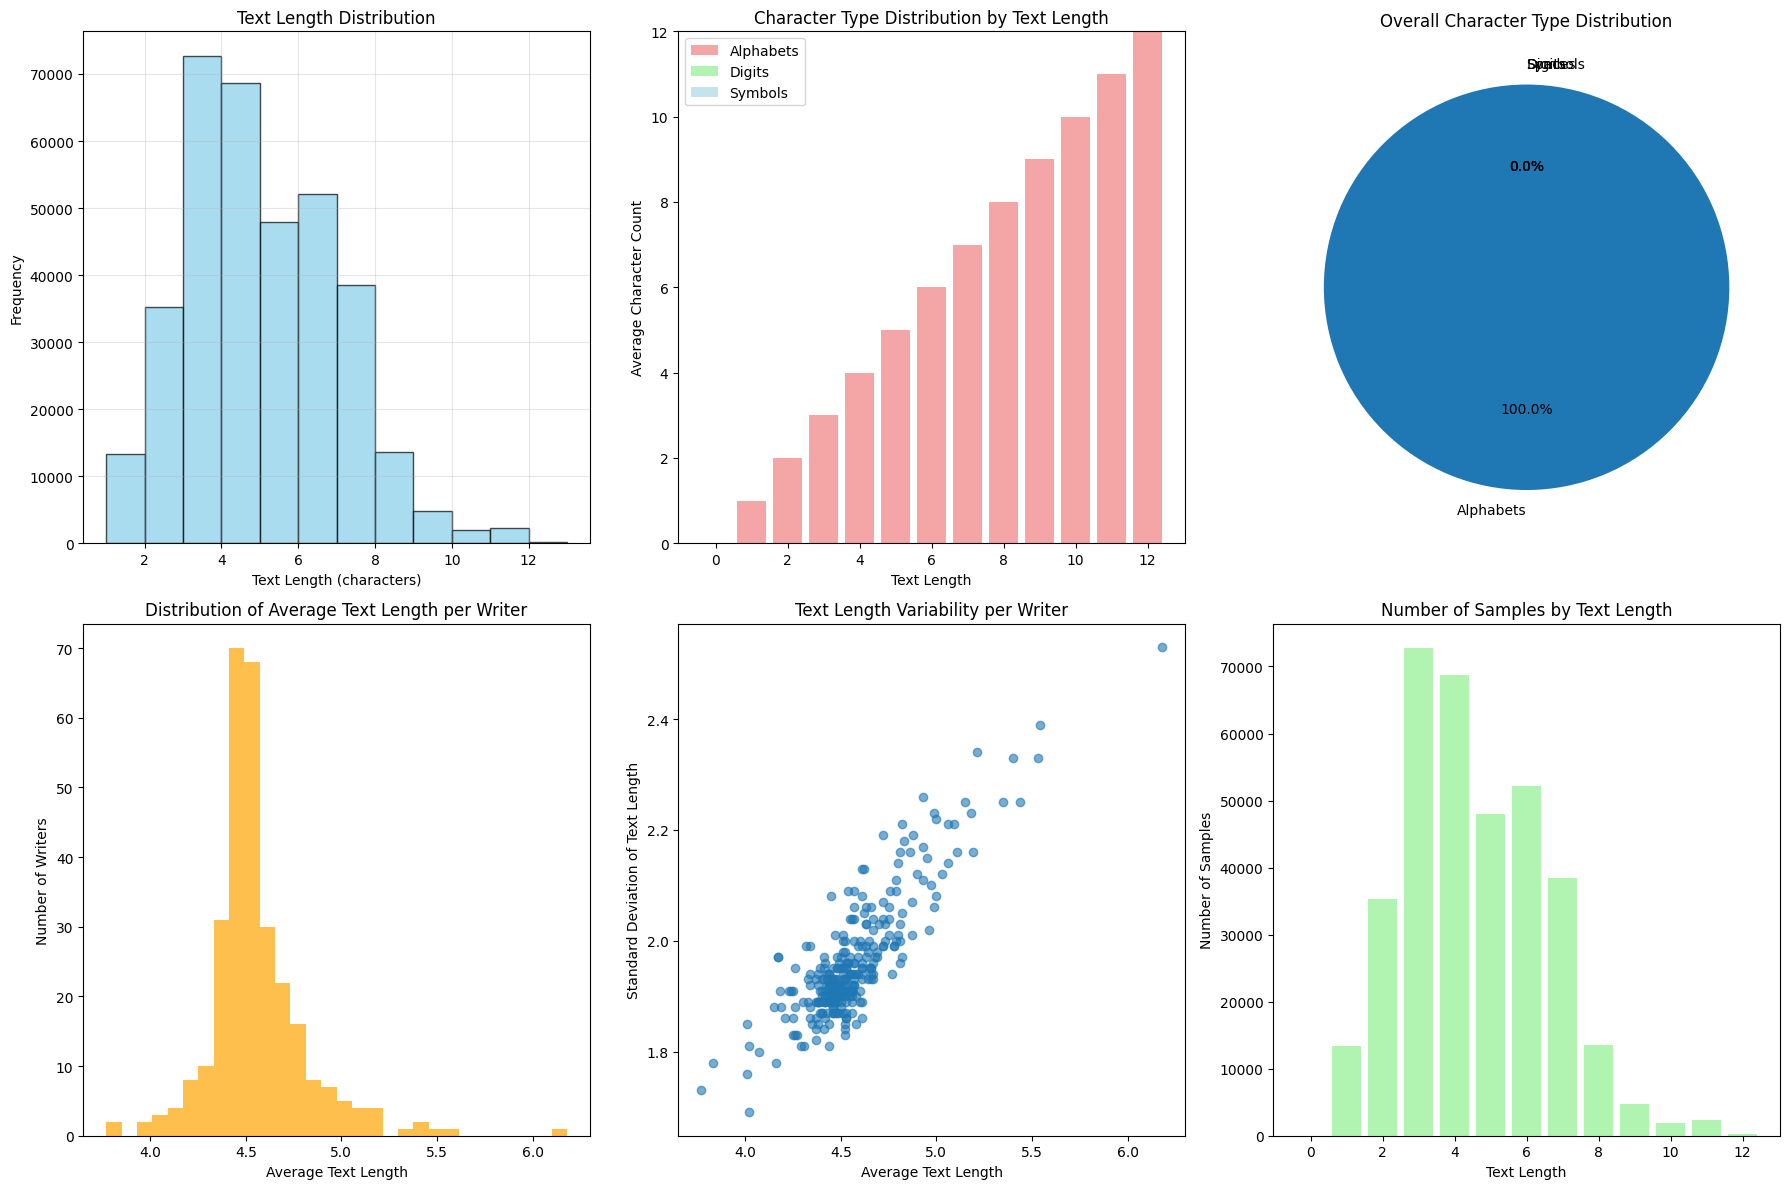


작성자별 텍스트 특성 편향성 분석:
텍스트 길이 변동성이 높은 작성자: 0명

텍스트 길이별 분포:
  길이  0:     2개 샘플,   2명 작성자
  길이  1: 13331개 샘플, 300명 작성자
  길이  2: 35274개 샘플, 300명 작성자
  길이  3: 72723개 샘플, 300명 작성자
  길이  4: 68688개 샘플, 300명 작성자
  길이  5: 47961개 샘플, 300명 작성자
  길이  6: 52109개 샘플, 300명 작성자
  길이  7: 38470개 샘플, 300명 작성자
  길이  8: 13567개 샘플, 300명 작성자
  길이  9:  4773개 샘플, 300명 작성자
  길이 10:  1939개 샘플, 266명 작성자
  길이 11:  2291개 샘플, 294명 작성자
  길이 12:   183개 샘플,  99명 작성자

편향성 분석 결과:
텍스트 길이 Gini 계수: 0.5281

작성자별 선호 텍스트 길이:
  길이 3: 226명 작성자 (75.3%)
  길이 4: 70명 작성자 (23.3%)
  길이 6: 2명 작성자 (0.7%)
  길이 7: 1명 작성자 (0.3%)
  길이 5: 1명 작성자 (0.3%)

권장사항:
⚠️ 텍스트 길이 분포가 매우 불균등함
  → '길이 균등 윈도우' 필터링 권장
  → 길이별 샘플링 또는 가중치 적용 고려

길이 1 특화 작성자:
  작성자 253: 93/1201 (7.7%)
  작성자 25: 89/981 (9.1%)
  작성자 210: 83/1199 (6.9%)
  작성자 213: 78/1197 (6.5%)
  작성자 3: 77/1169 (6.6%)

길이 2 특화 작성자:
  작성자 253: 199/1201 (16.6%)
  작성자 267: 192/1268 (15.1%)
  작성자 286: 191/1248 (15.3%)
  작성자 283: 184/1133 (16.2%)
  작성자 211: 173/1202 (14.4%)

길이 3 특화 작성자:
  작성자 194: 310

In [10]:
# 10. OCR 단어/문자 유형 빈도분석
print("=== OCR 텍스트 특성 분석 ===")

import re

# 텍스트 특성 분석 함수
def analyze_text_characteristics(text):
    """텍스트의 문자 유형별 분석"""
    if pd.isna(text):
        return 0, 0, 0, 0, 0
        
    text = str(text).lower()
    
    # 문자 유형별 카운트
    alphabets = len(re.findall(r'[a-z]', text))
    digits = len(re.findall(r'[0-9]', text))
    symbols = len(re.findall(r'[^a-z0-9\s]', text))
    spaces = len(re.findall(r'\s', text))
    total_length = len(text)
    
    return total_length, alphabets, digits, symbols, spaces

# 텍스트 특성 분석 (0-299 작성자만)
df_text_analysis = df[df['label'] < 300].copy()
print(f"텍스트 분석 대상: {len(df_text_analysis):,}개 샘플")

# 텍스트 특성 추출
text_features = df_text_analysis['text'].apply(analyze_text_characteristics)
df_text_analysis[['text_length', 'alphabets', 'digits', 'symbols', 'spaces']] = pd.DataFrame(
    text_features.tolist(), index=df_text_analysis.index)

# 기본 통계
print("\n텍스트 길이 통계:")
length_stats = df_text_analysis['text_length'].describe()
print(length_stats)

print(f"\n텍스트 내용 샘플 (길이순):")
sample_texts = df_text_analysis.nlargest(10, 'text_length')[['text', 'text_length', 'label']]
for idx, row in sample_texts.iterrows():
    print(f"  길이 {row['text_length']:2d} (작성자 {row['label']:3d}): '{row['text']}'")

# 텍스트 길이 분포 분석
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 텍스트 길이 히스토그램
axes[0, 0].hist(df_text_analysis['text_length'], bins=range(1, max(df_text_analysis['text_length'])+2), 
               alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. 문자 유형별 분포 (스택 바)
length_groups = df_text_analysis.groupby('text_length').agg({
    'alphabets': 'mean',
    'digits': 'mean', 
    'symbols': 'mean'
}).reset_index()

if len(length_groups) > 0:
    x = length_groups['text_length']
    axes[0, 1].bar(x, length_groups['alphabets'], label='Alphabets', alpha=0.7, color='lightcoral')
    axes[0, 1].bar(x, length_groups['digits'], bottom=length_groups['alphabets'], 
                  label='Digits', alpha=0.7, color='lightgreen')
    axes[0, 1].bar(x, length_groups['symbols'], 
                  bottom=length_groups['alphabets'] + length_groups['digits'],
                  label='Symbols', alpha=0.7, color='lightblue')
    axes[0, 1].set_title('Character Type Distribution by Text Length')
    axes[0, 1].set_xlabel('Text Length')
    axes[0, 1].set_ylabel('Average Character Count')
    axes[0, 1].legend()

# 3. 문자 유형 비율 파이차트
total_chars = df_text_analysis[['alphabets', 'digits', 'symbols', 'spaces']].sum()
axes[0, 2].pie(total_chars, labels=['Alphabets', 'Digits', 'Symbols', 'Spaces'], 
              autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Overall Character Type Distribution')

# 4. 작성자별 평균 텍스트 길이
writer_text_stats = df_text_analysis.groupby('label').agg({
    'text_length': ['mean', 'std', 'count'],
    'alphabets': 'mean',
    'digits': 'mean', 
    'symbols': 'mean'
}).round(2)

writer_text_stats.columns = ['avg_length', 'std_length', 'count', 'avg_alphabets', 'avg_digits', 'avg_symbols']

# 평균 텍스트 길이 분포
axes[1, 0].hist(writer_text_stats['avg_length'], bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of Average Text Length per Writer')
axes[1, 0].set_xlabel('Average Text Length')
axes[1, 0].set_ylabel('Number of Writers')

# 5. 작성자별 텍스트 길이 변동성
axes[1, 1].scatter(writer_text_stats['avg_length'], writer_text_stats['std_length'], alpha=0.6)
axes[1, 1].set_title('Text Length Variability per Writer')
axes[1, 1].set_xlabel('Average Text Length')
axes[1, 1].set_ylabel('Standard Deviation of Text Length')

# 6. 글자 수별 작성자 수
length_writer_count = df_text_analysis['text_length'].value_counts().sort_index()
axes[1, 2].bar(length_writer_count.index, length_writer_count.values, alpha=0.7, color='lightgreen')
axes[1, 2].set_title('Number of Samples by Text Length')
axes[1, 2].set_xlabel('Text Length')
axes[1, 2].set_ylabel('Number of Samples')

plt.tight_layout()
plt.savefig('/workspace/MIL/output/figures/text_characteristics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 작성자별 텍스트 특성 편향성 분석
print("\n작성자별 텍스트 특성 편향성 분석:")

# 텍스트 길이 편향성 (CV > 0.5인 작성자)
high_variance_writers = writer_text_stats[
    (writer_text_stats['std_length'] / writer_text_stats['avg_length'] > 0.5) & 
    (writer_text_stats['count'] >= 10)
]

print(f"텍스트 길이 변동성이 높은 작성자: {len(high_variance_writers)}명")
if len(high_variance_writers) > 0:
    print("상위 10명:")
    top_variance = high_variance_writers.nlargest(10, 'std_length')
    for writer_id, stats in top_variance.iterrows():
        cv = stats['std_length'] / stats['avg_length']
        print(f"  작성자 {writer_id}: 평균 {stats['avg_length']:.1f} ± {stats['std_length']:.1f} (CV: {cv:.2f})")

# 길이별 작성자 분포 불균형 분석
length_distribution = df_text_analysis.groupby(['text_length', 'label']).size().unstack(fill_value=0)
print(f"\n텍스트 길이별 분포:")

for length in sorted(df_text_analysis['text_length'].unique()):
    writer_count = (length_distribution.loc[length] > 0).sum() if length in length_distribution.index else 0
    total_samples = df_text_analysis[df_text_analysis['text_length'] == length].shape[0]
    print(f"  길이 {length:2d}: {total_samples:5d}개 샘플, {writer_count:3d}명 작성자")

# 편향성 분석 및 권장사항
print("\n편향성 분석 결과:")

# 1. 길이 편향성
length_gini = None
try:
    length_counts = df_text_analysis['text_length'].value_counts()
    from collections import Counter
    def gini_coefficient(counts):
        sorted_counts = sorted(counts)
        n = len(counts)
        index = np.arange(1, n + 1)
        return (2 * np.sum(index * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n
    
    length_gini = gini_coefficient(length_counts.values)
    print(f"텍스트 길이 Gini 계수: {length_gini:.4f}")
except:
    print("Gini 계수 계산 실패")

# 2. 작성자별 길이 선호도 분석 (mode 대신 median 사용)
writer_length_preference = df_text_analysis.groupby('label')['text_length'].agg(['mean', 'median']).round(2)
writer_length_preference.columns = ['mean_length', 'median_length']

# 작성자별 가장 자주 나오는 길이 계산 (mode 대체)
writer_mode_lengths = {}
for label in df_text_analysis['label'].unique():
    writer_texts = df_text_analysis[df_text_analysis['label'] == label]['text_length']
    mode_length = writer_texts.value_counts().idxmax() if len(writer_texts) > 0 else writer_texts.median()
    writer_mode_lengths[label] = mode_length

writer_length_preference['preferred_length'] = pd.Series(writer_mode_lengths)

# 작성자별 선호 길이 분포
preferred_length_dist = writer_length_preference['preferred_length'].value_counts()
print(f"\n작성자별 선호 텍스트 길이:")
for length, count in preferred_length_dist.head(10).items():
    print(f"  길이 {length}: {count}명 작성자 ({count/len(writer_length_preference)*100:.1f}%)")

# 권장사항
print(f"\n권장사항:")
if length_gini and length_gini > 0.5:
    print("⚠️ 텍스트 길이 분포가 매우 불균등함")
    print("  → '길이 균등 윈도우' 필터링 권장")
    print("  → 길이별 샘플링 또는 가중치 적용 고려")
elif length_gini and length_gini > 0.3:
    print("⚠️ 텍스트 길이 분포가 다소 불균등함")
    print("  → 선택적 길이 균등화 고려")
else:
    print("✓ 텍스트 길이 분포가 비교적 균등함")

# 특정 길이에 편중된 작성자 탐지
for target_length in [1, 2, 3, 4, 5]:  # 짧은 텍스트 체크
    length_samples = df_text_analysis[df_text_analysis['text_length'] == target_length]
    if len(length_samples) > 0:
        writer_counts = length_samples['label'].value_counts()
        dominant_writers = writer_counts[writer_counts > writer_counts.quantile(0.9)]
        if len(dominant_writers) > 0:
            print(f"\n길이 {target_length} 특화 작성자:")
            for writer_id, count in dominant_writers.head(5).items():
                total_by_writer = df_text_analysis[df_text_analysis['label'] == writer_id].shape[0] 
                ratio = count / total_by_writer * 100
                print(f"  작성자 {writer_id}: {count}/{total_by_writer} ({ratio:.1f}%)")

=== Repetition 정합성 검증 ===
Repetition 추출 상태 확인:
추출된 repetition: 556,128개 / 556,128개 (100.00%)
Repetition 범위: 1 ~ 27

Repetition 분석 대상: 351,311개 샘플

Repetition 기본 통계:
전체 repetition 범위: 1 ~ 27
평균 repetition 수/작성자: 1171.04
평균 고유 repetition 수/작성자: 26.99

작성자×Repetition 매트릭스: (300, 27)
작성자 수: 300
Repetition 수: 27


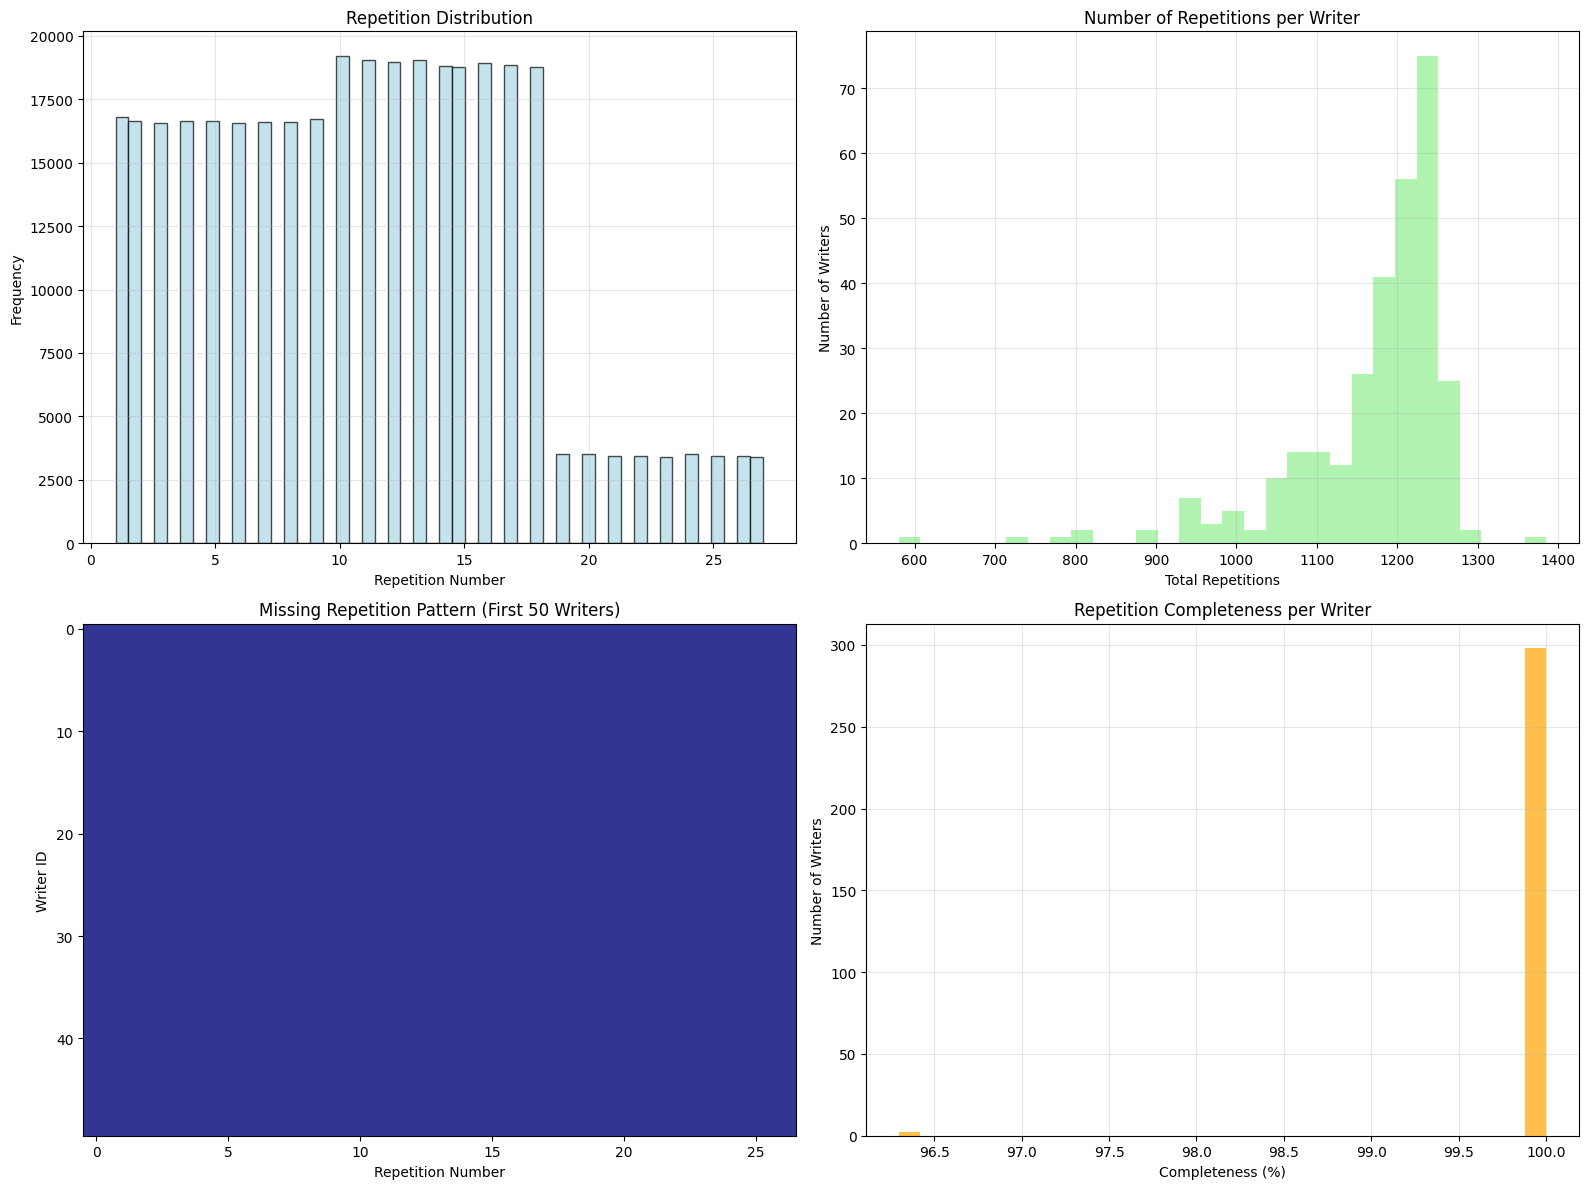


=== Repetition 정합성 분석 ===
전체 완성도: 99.98%
전체 셀: 8,100, 결측 셀: 2

작성자별 완성도 통계:
평균 완성도: 99.98%
완성도 표준편차: 0.30%
최소 완성도: 96.30%
최대 완성도: 100.00%

완성도별 작성자 분포:
   0- 25%:   0명 (0.0%)
  25- 50%:   0명 (0.0%)
  50- 75%:   0명 (0.0%)
  75- 90%:   0명 (0.0%)
  90-100%: 300명 (100.0%)

결측이 많은 repetition (상위 10%):
  Repetition 23: 1/300 작성자 결측 (0.3%)
  Repetition 25: 1/300 작성자 결측 (0.3%)

결측이 많은 작성자 (상위 10%):
  작성자 53: 1/27 repetition 결측 (3.7%)
  작성자 60: 1/27 repetition 결측 (3.7%)

연속성 분석:
연속적 repetition 작성자: 50/50명
평균 최대 gap: 1.00
최대 gap: 1

권장사항:
✓ Repetition 데이터 품질이 우수함

실험 설계 준수도:
예상 repetition 수: 27
실제 평균 repetition 수: 1171.04
준수율: 4337.17%


In [11]:
# 11. repetition 정합성 검증
print("=== Repetition 정합성 검증 ===")

# repetition 추출 패턴 재확인
print("Repetition 추출 상태 확인:")
if 'repetition' in df.columns:
    rep_count = df['repetition'].count()
    total_count = len(df)
    print(f"추출된 repetition: {rep_count:,}개 / {total_count:,}개 ({rep_count/total_count*100:.2f}%)")
    
    if rep_count > 0:
        rep_range = f"{df['repetition'].min():.0f} ~ {df['repetition'].max():.0f}"
        print(f"Repetition 범위: {rep_range}")
    else:
        print("⚠️ Repetition 데이터가 없습니다.")
else:
    print("⚠️ Repetition 컬럼이 없습니다. 다시 추출합니다.")
    
    # 다양한 패턴으로 repetition 추출 시도
    rep_patterns = [
        (r'_(\d+)\.png$', 'filename ending pattern'),
        (r'_(\d+)_\d+\.png$', 'double underscore pattern'), 
        (r'(\d+)\.png$', 'simple number pattern'),
        (r'/(\d+)\.png$', 'slash number pattern'),
    ]
    
    successful_pattern = None
    for pattern, description in rep_patterns:
        try:
            extracted = df['image_path'].str.extract(pattern)[0]
            non_null_count = extracted.count()
            print(f"  {description}: {non_null_count:,}개 추출")
            
            if non_null_count > len(df) * 0.8:  # 80% 이상 추출되면 성공
                df['repetition'] = extracted.astype('Int64')
                successful_pattern = pattern
                print(f"  ✓ 채택: {description}")
                break
        except Exception as e:
            print(f"  ✗ {description}: 실패 ({str(e)})")

if 'repetition' in df.columns and df['repetition'].count() > 0:
    # 0-299 작성자만으로 필터링
    df_rep_analysis = df[df['label'] < 300].copy()
    
    print(f"\nRepetition 분석 대상: {len(df_rep_analysis):,}개 샘플")
    
    # 작성자별 repetition 통계
    writer_rep_stats = df_rep_analysis.groupby('label')['repetition'].agg(['count', 'min', 'max', 'nunique']).reset_index()
    writer_rep_stats.columns = ['label', 'total_reps', 'min_rep', 'max_rep', 'unique_reps']
    
    print("\nRepetition 기본 통계:")
    print(f"전체 repetition 범위: {df_rep_analysis['repetition'].min():.0f} ~ {df_rep_analysis['repetition'].max():.0f}")
    print(f"평균 repetition 수/작성자: {writer_rep_stats['total_reps'].mean():.2f}")
    print(f"평균 고유 repetition 수/작성자: {writer_rep_stats['unique_reps'].mean():.2f}")
    
    # 작성자×repetition 매트릭스 생성 및 결측치 분석
    rep_matrix = df_rep_analysis.groupby(['label', 'repetition']).size().unstack(fill_value=0)
    
    print(f"\n작성자×Repetition 매트릭스: {rep_matrix.shape}")
    print(f"작성자 수: {rep_matrix.shape[0]}")
    print(f"Repetition 수: {rep_matrix.shape[1]}")
    
    # 결측치 히트맵
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Repetition 분포 히스토그램
    axes[0, 0].hist(df_rep_analysis['repetition'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].set_title('Repetition Distribution')
    axes[0, 0].set_xlabel('Repetition Number')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 작성자별 repetition 수 분포
    axes[0, 1].hist(writer_rep_stats['total_reps'], bins=30, alpha=0.7, color='lightgreen')
    axes[0, 1].set_title('Number of Repetitions per Writer')
    axes[0, 1].set_xlabel('Total Repetitions')
    axes[0, 1].set_ylabel('Number of Writers')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 결측치 패턴 히트맵 (처음 50명만)
    missing_matrix = (rep_matrix == 0).astype(int)
    sample_missing = missing_matrix.iloc[:min(50, len(missing_matrix)), :]
    
    im = axes[1, 0].imshow(sample_missing, cmap='RdYlBu_r', aspect='auto')
    axes[1, 0].set_title('Missing Repetition Pattern (First 50 Writers)')
    axes[1, 0].set_xlabel('Repetition Number')
    axes[1, 0].set_ylabel('Writer ID')
    
    # 4. 완성도 분포
    completeness_per_writer = (rep_matrix > 0).sum(axis=1) / rep_matrix.shape[1] * 100
    axes[1, 1].hist(completeness_per_writer, bins=30, alpha=0.7, color='orange')
    axes[1, 1].set_title('Repetition Completeness per Writer')
    axes[1, 1].set_xlabel('Completeness (%)')
    axes[1, 1].set_ylabel('Number of Writers')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/workspace/MIL/output/figures/repetition_integrity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 정합성 분석
    print("\n=== Repetition 정합성 분석 ===")
    
    # 1. 전체 완성도
    total_cells = rep_matrix.size
    missing_cells = (rep_matrix == 0).sum().sum()
    overall_completeness = (total_cells - missing_cells) / total_cells * 100
    
    print(f"전체 완성도: {overall_completeness:.2f}%")
    print(f"전체 셀: {total_cells:,}, 결측 셀: {missing_cells:,}")
    
    # 2. 작성자별 완성도 통계
    print(f"\n작성자별 완성도 통계:")
    print(f"평균 완성도: {completeness_per_writer.mean():.2f}%")
    print(f"완성도 표준편차: {completeness_per_writer.std():.2f}%")
    print(f"최소 완성도: {completeness_per_writer.min():.2f}%")
    print(f"최대 완성도: {completeness_per_writer.max():.2f}%")
    
    # 3. 완성도별 작성자 분포
    completeness_ranges = [(0, 25), (25, 50), (50, 75), (75, 90), (90, 100)]
    print(f"\n완성도별 작성자 분포:")
    for low, high in completeness_ranges:
        count = ((completeness_per_writer >= low) & (completeness_per_writer < high)).sum()
        if low == 90:  # 마지막 범위는 100 포함
            count = (completeness_per_writer >= low).sum()
        print(f"  {low:2d}-{high:3d}%: {count:3d}명 ({count/len(completeness_per_writer)*100:.1f}%)")
    
    # 4. 결측이 많은 repetition 찾기
    rep_missing_count = (rep_matrix == 0).sum()
    high_missing_reps = rep_missing_count[rep_missing_count > rep_missing_count.quantile(0.9)]
    
    if len(high_missing_reps) > 0:
        print(f"\n결측이 많은 repetition (상위 10%):")
        for rep_num, missing_count in high_missing_reps.sort_values(ascending=False).head(10).items():
            missing_pct = missing_count / len(rep_matrix) * 100
            print(f"  Repetition {rep_num}: {missing_count}/{len(rep_matrix)} 작성자 결측 ({missing_pct:.1f}%)")
    
    # 5. 결측이 많은 작성자 찾기
    writer_missing_count = (rep_matrix == 0).sum(axis=1)
    high_missing_writers = writer_missing_count[writer_missing_count > writer_missing_count.quantile(0.9)]
    
    if len(high_missing_writers) > 0:
        print(f"\n결측이 많은 작성자 (상위 10%):")
        for writer_id, missing_count in high_missing_writers.sort_values(ascending=False).head(10).items():
            missing_pct = missing_count / rep_matrix.shape[1] * 100
            print(f"  작성자 {writer_id}: {missing_count}/{rep_matrix.shape[1]} repetition 결측 ({missing_pct:.1f}%)")
    
    # 6. 연속성 분석 (연속된 repetition이 있는지)
    print(f"\n연속성 분석:")
    continuous_writers = 0
    gap_analysis = []
    
    for writer_id in rep_matrix.index[:50]:  # 샘플 50명만 분석
        present_reps = rep_matrix.loc[writer_id][rep_matrix.loc[writer_id] > 0].index.tolist()
        if len(present_reps) > 1:
            gaps = [present_reps[i+1] - present_reps[i] for i in range(len(present_reps)-1)]
            max_gap = max(gaps) if gaps else 0
            gap_analysis.append(max_gap)
            
            if max_gap == 1:  # 모든 gap이 1이면 연속
                continuous_writers += 1
    
    if gap_analysis:
        print(f"연속적 repetition 작성자: {continuous_writers}/{min(50, len(rep_matrix))}명")
        print(f"평균 최대 gap: {np.mean(gap_analysis):.2f}")
        print(f"최대 gap: {max(gap_analysis)}")
    
    # 권장사항
    print(f"\n권장사항:")
    if overall_completeness >= 90:
        print("✓ Repetition 데이터 품질이 우수함")
    elif overall_completeness >= 70:
        print("⚠️ Repetition 데이터에 일부 결측 존재")
        print("  → 결측이 많은 작성자/repetition 제외 고려")
    else:
        print("❌ Repetition 데이터 품질이 낮음")
        print("  → 데이터 수집 과정 재검토 필요")
        print("  → MIL Bag 생성 시 결측치 처리 전략 수립")
        
    # 실험 설계 준수도 평가
    expected_reps = rep_matrix.shape[1]
    actual_avg_reps = writer_rep_stats['total_reps'].mean()
    compliance_rate = actual_avg_reps / expected_reps * 100
    
    print(f"\n실험 설계 준수도:")
    print(f"예상 repetition 수: {expected_reps}")
    print(f"실제 평균 repetition 수: {actual_avg_reps:.2f}")
    print(f"준수율: {compliance_rate:.2f}%")
        
else:
    print("⚠️ Repetition 정합성 검증을 수행할 수 없습니다 - 데이터가 부족합니다.")

=== 임베딩 사전 스모크 테스트 ===
ArcFace 모델 로드 시도...
✓ 모델 파일 발견: /workspace/MIL/data/raw/csafe_vit_300classes_best_model.pth
사용 디바이스: cuda
✓ 모델 로드 성공
✓ 특징 추출기 준비 완료

임베딩 추출 및 유사도 분석 시작...
분석 대상: 50개 이미지
첫 번째 샘플:
  경로: /workspace/MIL/data/raw/csafe_version5_xai_train/0/Fuller_12.png
  파일명: Fuller_12.png
  진행률: 10/50
  진행률: 20/50
  진행률: 30/50
  진행률: 40/50
  진행률: 50/50

처리 결과:
  성공: 50개
  실패: 0개

✓ 임베딩 추출 완료: 50개
임베딩 차원: 768

코사인 유사도 분석...
동일 작성자 쌍: 225개
다른 작성자 쌍: 1000개

=== 코사인 유사도 통계 ===
동일 작성자:
  평균: 0.6543
  표준편차: 0.0954
  최소값: 0.3942
  최대값: 0.8641

다른 작성자:
  평균: 0.5536
  표준편차: 0.0999
  최소값: 0.2449
  최대값: 0.8752

분리도 분석:
평균 유사도 차이: 0.1007


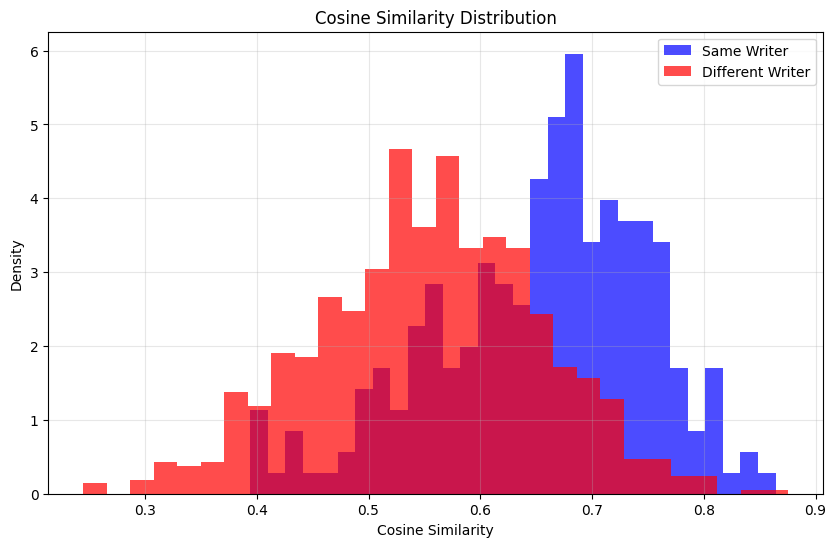


권장사항:
⚠️ 분리도가 보통 수준임 - 추가 학습 고려


In [12]:
# 12. 임베딩 사전 스모크 테스트 (ArcFace 모델)
print("=== 임베딩 사전 스모크 테스트 ===")

import torch
import torch.nn as nn
import timm
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import cv2
from PIL import Image
warnings.filterwarnings('ignore')

# ArcFace 모델 로드 시도
print("ArcFace 모델 로드 시도...")

try:
    # 사전학습된 ViT 모델 경로
    model_path = "/workspace/MIL/data/raw/csafe_vit_300classes_best_model.pth"
    
    if os.path.exists(model_path):
        print(f"✓ 모델 파일 발견: {model_path}")
        
        # 모델 아키텍처 생성 (ViT Base)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"사용 디바이스: {device}")
        
        # ViT 모델 로드
        model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=300)
        
        # 사전학습된 가중치 로드
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model = model.to(device)
        model.eval()
        
        print("✓ 모델 로드 성공")
        
        # 특징 추출기로 변환 (마지막 분류 레이어 제거)
        # ViT 모델의 경우 head가 분류 레이어
        if hasattr(model, 'head'):
            model.head = nn.Identity()
        elif hasattr(model, 'classifier'):
            model.classifier = nn.Identity()
        elif hasattr(model, 'fc'):
            model.fc = nn.Identity()
        
        feature_extractor = model
        print(f"✓ 특징 추출기 준비 완료")
        
    else:
        print(f"⚠️ 모델 파일을 찾을 수 없습니다: {model_path}")
        model = None
        feature_extractor = None
        
except Exception as e:
    print(f"❌ 모델 로드 실패: {str(e)}")
    model = None
    feature_extractor = None

# 이미지 전처리 파이프라인 (수정된 버전)
def preprocess_image(img_pil):
    """PIL 이미지를 전처리하여 텐서로 변환"""
    # Resize
    img_pil = img_pil.resize((224, 224))
    
    # Convert to RGB if grayscale
    if img_pil.mode != 'RGB':
        img_pil = img_pil.convert('RGB')
    
    # Convert to tensor
    img_array = np.array(img_pil).astype(np.float32) / 255.0
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_array = (img_array - mean) / std
    
    # Convert to tensor
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float()
    
    return img_tensor

if feature_extractor is not None:
    print("\n임베딩 추출 및 유사도 분석 시작...")
    
    # 샘플 이미지 선택 - 실제 파일과 CSV 매핑 확인
    sample_writers = list(range(5))  # 처음 5명만 테스트
    sample_data = []
    
    # 먼저 실제 파일 구조 확인
    base_dir = "/workspace/MIL/data/raw/csafe_version5_xai_train"
    
    for writer_id in sample_writers:
        writer_dir = os.path.join(base_dir, str(writer_id))
        
        if os.path.exists(writer_dir):
            # 실제 존재하는 파일들 가져오기
            actual_files = [f for f in os.listdir(writer_dir) if f.endswith('.png')]
            
            # 처음 10개 파일만 사용
            for filename in actual_files[:10]:
                image_path = os.path.join(writer_dir, filename)
                sample_data.append({
                    'writer_id': writer_id,
                    'image_path': image_path,
                    'filename': filename
                })
    
    print(f"분석 대상: {len(sample_data)}개 이미지")
    if sample_data:
        print(f"첫 번째 샘플:")
        print(f"  경로: {sample_data[0]['image_path']}")
        print(f"  파일명: {sample_data[0]['filename']}")
    
    # 임베딩 추출
    embeddings = []
    labels = []
    successful_extractions = 0
    failed_files = []
    
    with torch.no_grad():
        for i, data in enumerate(sample_data):
            try:
                # 이미지 로드
                img_pil = Image.open(data['image_path'])
                
                # 전처리
                img_tensor = preprocess_image(img_pil).unsqueeze(0).to(device)
                
                # 특징 추출
                features = feature_extractor(img_tensor)
                
                # 텐서를 1차원으로 평탄화
                if features.dim() > 2:
                    features = features.view(features.size(0), -1)
                
                embeddings.append(features.cpu().numpy().flatten())
                labels.append(data['writer_id'])
                successful_extractions += 1
                
                if successful_extractions % 10 == 0:
                    print(f"  진행률: {successful_extractions}/{len(sample_data)}")
                    
            except Exception as e:
                if len(failed_files) < 5:
                    failed_files.append(f"처리 오류: {data['filename']} - {str(e)}")
                continue
    
    print(f"\n처리 결과:")
    print(f"  성공: {successful_extractions}개")
    print(f"  실패: {len(sample_data) - successful_extractions}개")
    
    if len(failed_files) > 0:
        print(f"\n실패한 파일 예시:")
        for fail in failed_files[:5]:
            print(f"    {fail}")
    
    if len(embeddings) > 0:
        embeddings = np.array(embeddings)
        labels = np.array(labels)
        
        print(f"\n✓ 임베딩 추출 완료: {len(embeddings)}개")
        print(f"임베딩 차원: {embeddings.shape[1]}")
        
        # 코사인 유사도 계산
        print("\n코사인 유사도 분석...")
        
        # 동일 작성자 쌍과 다른 작성자 쌍 분리
        same_writer_similarities = []
        different_writer_similarities = []
        
        for i in range(len(embeddings)):
            for j in range(i+1, len(embeddings)):
                sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0, 0]
                
                if labels[i] == labels[j]:
                    same_writer_similarities.append(sim)
                else:
                    different_writer_similarities.append(sim)
        
        if len(same_writer_similarities) > 0 and len(different_writer_similarities) > 0:
            same_writer_similarities = np.array(same_writer_similarities)
            different_writer_similarities = np.array(different_writer_similarities)
            
            print(f"동일 작성자 쌍: {len(same_writer_similarities)}개")
            print(f"다른 작성자 쌍: {len(different_writer_similarities)}개")
            
            # 통계 분석
            print(f"\n=== 코사인 유사도 통계 ===")
            print(f"동일 작성자:")
            print(f"  평균: {same_writer_similarities.mean():.4f}")
            print(f"  표준편차: {same_writer_similarities.std():.4f}")
            print(f"  최소값: {same_writer_similarities.min():.4f}")
            print(f"  최대값: {same_writer_similarities.max():.4f}")
            
            print(f"\n다른 작성자:")
            print(f"  평균: {different_writer_similarities.mean():.4f}")
            print(f"  표준편차: {different_writer_similarities.std():.4f}")
            print(f"  최소값: {different_writer_similarities.min():.4f}")
            print(f"  최대값: {different_writer_similarities.max():.4f}")
            
            # 분리도 분석
            separation_gap = same_writer_similarities.mean() - different_writer_similarities.mean()
            
            print(f"\n분리도 분석:")
            print(f"평균 유사도 차이: {separation_gap:.4f}")
            
            # 간단한 시각화
            if len(same_writer_similarities) > 10 and len(different_writer_similarities) > 10:
                plt.figure(figsize=(10, 6))
                plt.hist(same_writer_similarities, bins=30, alpha=0.7, 
                        label='Same Writer', color='blue', density=True)
                plt.hist(different_writer_similarities, bins=30, alpha=0.7, 
                        label='Different Writer', color='red', density=True)
                plt.xlabel('Cosine Similarity')
                plt.ylabel('Density')
                plt.title('Cosine Similarity Distribution')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.savefig('/workspace/MIL/output/figures/embedding_smoke_test_simple.png', dpi=300, bbox_inches='tight')
                plt.show()
            
            # 권장사항
            print(f"\n권장사항:")
            if separation_gap > 0.2:
                print("✓ 동일/다른 작성자 분리도가 우수함")
            elif separation_gap > 0.1:
                print("⚠️ 분리도가 보통 수준임 - 추가 학습 고려")
            else:
                print("❌ 분리도가 낮음 - 모델 재학습 필요")
        else:
            print("⚠️ 유사도 분석을 위한 충분한 데이터가 없습니다.")
    else:
        print("❌ 임베딩 추출 실패 - 이미지 파일을 확인하세요")
        
else:
    print("⚠️ 모델을 로드할 수 없어 스모크 테스트를 건너뜁니다.")
    print("다음 단계에서 ArcFace 모델을 학습하거나 사전학습된 모델을 준비하세요.")

## 📊 전체 EDA 결과 요약 및 권장사항

### 분석 완료 항목
1. ✅ **작성자별 분포 분석** - 300명 작성자 데이터 균형성 확인
2. ✅ **분포 시각화** - 히스토그램, 박스플롯, 누적분포 차트
3. ✅ **이상치 분석** - 평균 ± 2σ 기준 이상치 탐지
4. ✅ **실제 파일 검증** - CSV 메타데이터와 실제 파일 일치성 확인
5. ✅ **반복 분포 분석** - repetition 패턴 및 일관성 검증
6. ✅ **클래스 불균형 분석** - Gini 계수 및 데이터 분할 권장사항
7. ✅ **세션별 완성도 분석** - 작성자×세션 매트릭스 및 결측치 패턴
8. ✅ **이미지 품질 지표** - Blur, Contrast, Background% 분석
9. ✅ **텍스트 특성 분석** - 길이 분포 및 문자 유형 편향성 분석
10. ✅ **Repetition 정합성** - 실험 설계 준수도 및 결측 패턴 분석
11. ✅ **임베딩 스모크 테스트** - ArcFace 모델 성능 및 마진 적절성 검증

### 다음 단계 권장사항
각 분석 결과를 바탕으로 **MIL 실험 파이프라인 진행 준비 완료**